# Artificial neural networks

```{warning}
This chapter is under construction.
```

## Environment setup

In [1]:
import platform

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import sklearn
from sklearn.datasets import make_circles

import torch
from torch import nn
from torch.utils.data import DataLoader

In [2]:
# Setup plots

# Include matplotlib graphs into the notebook, next to the code
# https://stackoverflow.com/a/43028034/2380880
%matplotlib inline

# Improve plot quality
%config InlineBackend.figure_format = "retina"

# Setup seaborn default theme
# http://seaborn.pydata.org/generated/seaborn.set_theme.html#seaborn.set_theme
sns.set_theme()

In [3]:
# Print environment info
print(f"Python version: {platform.python_version()}")
print(f"NumPy version: {np.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"PyTorch version: {torch.__version__}")


# PyTorch device configuration
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA GPU {torch.cuda.get_device_name(0)} found :)")
# Performance issues exist with MPS backend
# elif torch.backends.mps.is_available():
#     device = torch.device("mps")
#     print("Metal GPU found :)")
else:
    device = torch.device("cpu")
    print("No GPU found, using CPU instead")

Python version: 3.11.1
NumPy version: 1.26.3
scikit-learn version: 1.3.2
PyTorch version: 2.0.1
No GPU found, using CPU instead


In [4]:
# Utility functions


def plot_dataset(x, y):
    """Plot a 2-dimensional dataset with associated classes"""

    plt.figure()
    plt.plot(x[y == 0, 0], x[y == 0, 1], "or", label=0)
    plt.plot(x[y == 1, 0], x[y == 1, 1], "ob", label=1)
    plt.legend()
    plt.show()


def plot_decision_boundary(model, x, y):
    """Plot the frontier between classes for a 2-dimensional dataset"""

    plt.figure()

    # Set min and max values and give it some padding
    x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
    y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Compute model output for the whole grid
    z = model(torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float().to(device))
    z = z.reshape(xx.shape)
    # Convert PyTorch tensor to NumPy
    zz = z.cpu().detach().numpy()
    # Plot the contour and training examples
    plt.contourf(xx, yy, zz, cmap=plt.colormaps.get_cmap("Spectral"))
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=cm_bright)
    plt.show()


def plot_loss_acc(history):
    """Plot training loss and accuracy. Takes a Keras-like History object as parameter"""

    loss_values = history["loss"]
    recorded_epochs = range(1, len(loss_values) + 1)

    fig, (ax1, ax2) = plt.subplots(2, 1)
    ax1.plot(recorded_epochs, loss_values, ".--", label="Training loss")
    ax1.set_ylabel("Loss")
    ax1.legend()

    acc_values = history["acc"]
    ax2.plot(recorded_epochs, acc_values, ".--", label="Training accuracy")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.legend()

    final_loss = loss_values[-1]
    final_acc = acc_values[-1]
    fig.suptitle(
        f"Training loss: {final_loss:.5f}. Training accuracy: {final_acc*100:.2f}%"
    )
    plt.show()

## Fundamentals

### Online playground

[![TensorFlow playground](_images/tf_playground.png)](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.1&regularizationRate=0&noise=0&networkShape=2&seed=0.59857&showTestData=false&discretize=false&percTrainData=30&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false&showTestData_hide=false&problem_hide=true&regularization_hide=true&regularizationRate_hide=true&percTrainData_hide=false)

### Activation functions

### Training process

## BInary classification

### Data generation

inputs: (500, 2). targets: (500,)


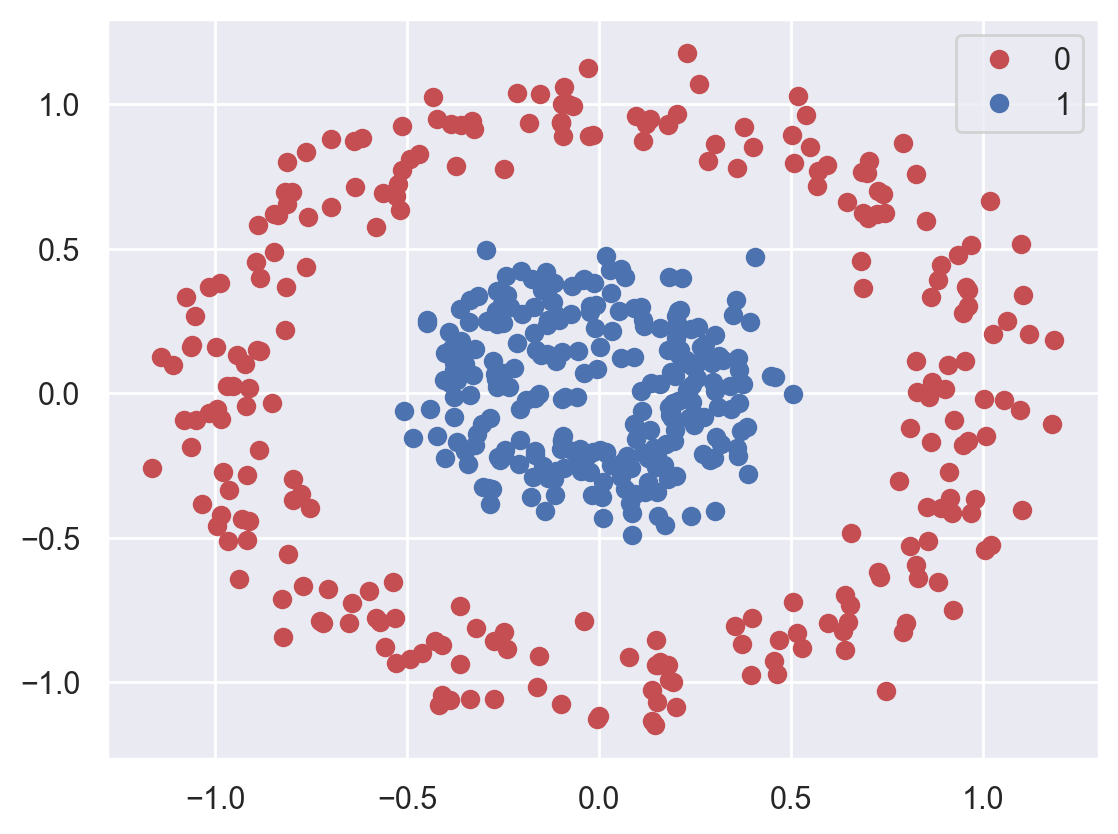

In [5]:
# Generate 2D data (a large circle containing a smaller circle)
inputs, targets = make_circles(n_samples=500, noise=0.1, factor=0.3)
print(f"inputs: {inputs.shape}. targets: {targets.shape}")

plot_dataset(inputs, targets)

### Hyperparameters

In [6]:
# Rate of parameter change during gradient descent
learning_rate = 0.1

# An epoch is finished when all data samples have been presented to the model during training
n_epochs = 50

# Number of samples used for one gradient descent step during training
batch_size = 5

# Number of neurons on the hidden layer of the MLP
hidden_layer_size = 2

### Data preparation

In [7]:
# Create PyTorch tensors from NumPy tensors

x_train = torch.from_numpy(inputs).float().to(device)

# PyTorch loss function expects float results of shape (batch_size, 1) instead of (batch_size,)
# So we add a new axis and convert them to floats
y_train = torch.from_numpy(targets[:, np.newaxis]).float().to(device)

print(f"x_train: {x_train.shape}. y_train: {y_train.shape}")

x_train: torch.Size([500, 2]). y_train: torch.Size([500, 1])


In [8]:
# Load data as randomized batches for training
train_dataloader = DataLoader(
    list(zip(x_train, y_train)), batch_size=batch_size, shuffle=True
)

# Number of samples
n_samples = len(train_dataloader.dataset)

# Number of batches in an epoch (= n_samples / batch_size, rounded up)
n_batches = len(train_dataloader)

### Model definition

In [9]:
# Create a MultiLayer Perceptron with 2 inputs and 1 output
# You may change its internal architecture:
# for example, try adding one neuron on the hidden layer and check training results
mlp_clf = nn.Sequential(
    nn.Linear(2, hidden_layer_size),
    nn.Tanh(),
    nn.Linear(hidden_layer_size, 1),
    nn.Sigmoid(),
).to(device)
print(mlp_clf)

n_parameters = sum(p.numel() for p in mlp_clf.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {n_parameters}")

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=1, bias=True)
  (3): Sigmoid()
)
Number of trainable parameters: 9


### Loss function

In [10]:
# Binary Cross Entropy loss function
loss_fn = nn.BCELoss()

# Object storing training history
train_history = {"loss": [], "acc": []}

### Model training

In [11]:
# Main training loop
for epoch in range(n_epochs):
    epoch_loss = 0

    # Reset number of correct predictions for the current epoch
    epoch_correct = 0

    # Training loop for one data batch (i.e. one gradient descent step)
    for x_batch, y_batch in train_dataloader:
        # Forward pass: compute model output with current weights
        y_pred_batch = mlp_clf(x_batch)

        # Compute loss (comparison between expected and actual results)
        loss = loss_fn(y_pred_batch, y_batch)

        # Zero the gradients before running the backward pass
        # Avoids accumulating gradients erroneously
        mlp_clf.zero_grad()

        # Backward pass (backprop): compute gradient of the loss w.r.t each model weight
        loss.backward()

        # Gradient descent step: update the weights in the opposite direction of their gradient
        # no_grad() avoids tracking operations history, which would be useless here
        with torch.no_grad():
            for param in mlp_clf.parameters():
                param -= learning_rate * param.grad

        # Accumulate data for epoch metrics: loss and number of correct predictions
        epoch_loss += loss.item()
        epoch_correct += (torch.round(mlp_clf(x_batch)) == y_batch).float().sum().item()

    # Compute epoch metrics
    epoch_loss /= n_batches
    epoch_acc = epoch_correct / n_samples

    print(
        f"Epoch [{(epoch + 1):3}/{n_epochs:3}]. Mean loss: {epoch_loss:.5f}. Accuracy: {epoch_acc * 100:.2f}%"
    )

    # Record epoch metrics for later plotting
    train_history["loss"].append(epoch_loss)
    train_history["acc"].append(epoch_acc)


print("Training complete!")
print(f"Total gradient descent steps: {n_epochs * n_batches}.")

Epoch [  1/ 50]. Mean loss: 0.70334. Accuracy: 58.60%
Epoch [  2/ 50]. Mean loss: 0.69329. Accuracy: 55.60%
Epoch [  3/ 50]. Mean loss: 0.69090. Accuracy: 60.60%
Epoch [  4/ 50]. Mean loss: 0.68698. Accuracy: 61.00%
Epoch [  5/ 50]. Mean loss: 0.67962. Accuracy: 65.40%
Epoch [  6/ 50]. Mean loss: 0.66668. Accuracy: 65.00%
Epoch [  7/ 50]. Mean loss: 0.65045. Accuracy: 68.20%
Epoch [  8/ 50]. Mean loss: 0.62199. Accuracy: 76.80%
Epoch [  9/ 50]. Mean loss: 0.58244. Accuracy: 81.60%
Epoch [ 10/ 50]. Mean loss: 0.54336. Accuracy: 85.60%
Epoch [ 11/ 50]. Mean loss: 0.50302. Accuracy: 84.80%
Epoch [ 12/ 50]. Mean loss: 0.47359. Accuracy: 85.20%
Epoch [ 13/ 50]. Mean loss: 0.45086. Accuracy: 84.20%
Epoch [ 14/ 50]. Mean loss: 0.43572. Accuracy: 83.80%
Epoch [ 15/ 50]. Mean loss: 0.42522. Accuracy: 84.40%
Epoch [ 16/ 50]. Mean loss: 0.41733. Accuracy: 84.60%
Epoch [ 17/ 50]. Mean loss: 0.41048. Accuracy: 84.40%
Epoch [ 18/ 50]. Mean loss: 0.40564. Accuracy: 85.60%
Epoch [ 19/ 50]. Mean loss: 

### Training results

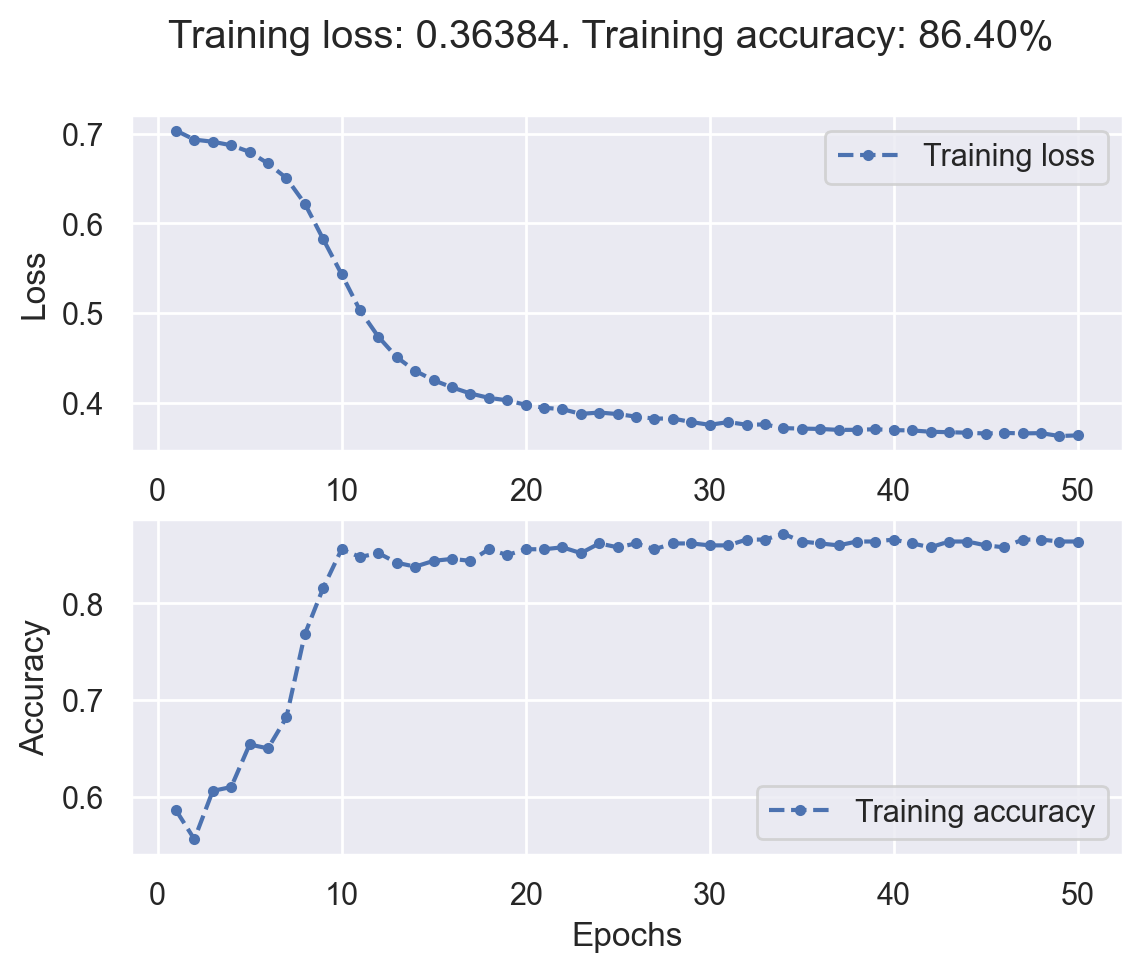

In [12]:
plot_loss_acc(train_history)

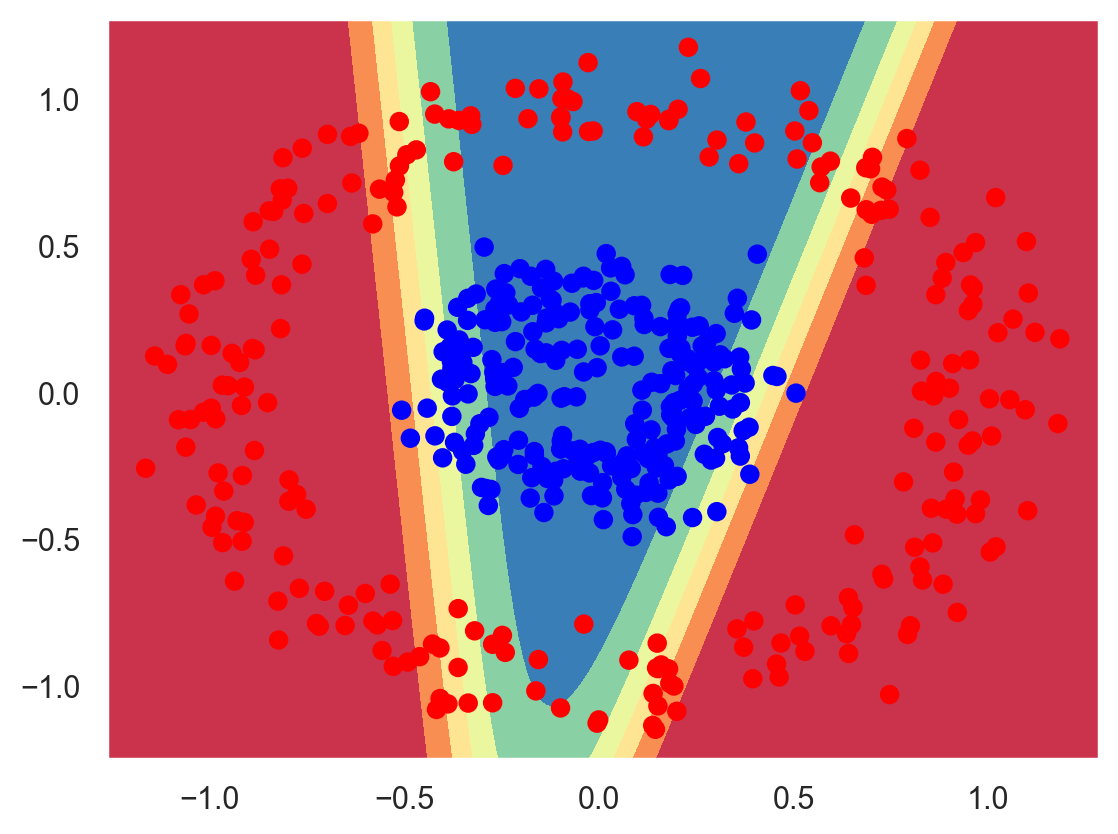

In [13]:
plot_decision_boundary(mlp_clf, inputs, targets)

## Multiclass classification

## Regression